In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


In [ ]:
caminho = r"/content/drive/MyDrive/8ºSEMESTRE/TG/base_final.parquet"
base = pd.read_parquet(caminho)
base = base[base['var_2'] > 15]

In [ ]:
base['var_325'] = base['var_325'].astype('category')
base['var_1'] = base['var_1'].astype('category')
base['var_339'] = base['var_339'].astype('category')
base['CAT_var_275'] = base['CAT_var_275'].astype('category')
base['var_365'] = base['var_365'].astype('category')
base = base[base['var_2'] > 15]
# base['var_resposta'] = base['var_resposta'].astype('category')

In [ ]:
# base["var_resposta"] = 1-base["var_resposta"]

# base["var_resposta"]= base["var_resposta"].astype('category')

In [ ]:
# base_norma = pd.concat([base_norma, Data_Continuous_df], axis = 1)
# print(base_norma.columns)
base["var_resposta"]

,var_resposta
0,0
1,0
2,0
3,0
4,0
...,...
411464,0
411465,0
411466,1
411467,0


In [ ]:
treino = base[base['split'] == "Treinamento"]
import random
np.random.seed(290)
split = np.random.choice(['Treinamento', 'Validacao'], size = len(treino), p = [0.8, 0.2])

# Adicionando a coluna 'split' na base de dados
treino['split'] = split
print(treino['split'].value_counts())

split
Treinamento    263226
Validacao       65773
Name: count, dtype: int64


<ipython-input-36-edcd998e3244>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['split'] = split


In [ ]:
treinof = treino[treino['split'] == "Treinamento"]
treinof = treinof.drop(columns = ["split"])

X_treino = treinof.drop(["var_resposta"],axis=1)
Y_treino = treinof["var_resposta"]
print(X_treino.shape)

(263226, 213)


In [ ]:
valid = treino[treino['split'] == "Validacao"]
valid = valid.drop(columns = ["split"])


X_valid = valid.drop(["var_resposta"],axis=1)
Y_valid = valid["var_resposta"]
print(X_valid.shape)


(65773, 213)


In [ ]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]
print(X_teste.shape)

(82470, 213)


In [ ]:
Y_teste.value_counts()

,count
var_resposta,
0,78076
1,4394


In [ ]:
# !pip install bayes_opt
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
import optuna
from sklearn import metrics

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "logloss",
        'force_col_wise': True,
        #"boosting_type": "goss",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 50, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 8, 15),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "min_split_gain":trial.suggest_float("min_split_gain", 0.001, 0.02),
        "lambda_l1":trial.suggest_float("lambda_l1", 0, 1),
        "lambda_l2":trial.suggest_float("lambda_l2", 0, 1)

    }

    class_lgbm = lgb.LGBMClassifier(**params)
    class_lgbm.fit(X_treino, Y_treino)
    predicoes = class_lgbm.predict_proba(X_valid)[:, 1]
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc


In [ ]:
# Criando o estudo e otimizando
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-10-09 15:14:08,256] A new study created in memory with name: no-name-5661b999-6873-439c-b662-5ff0d86adf8c


[LightGBM] [Warning] lambda_l2 is set=0.12368704005612485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12368704005612485
[LightGBM] [Warning] lambda_l1 is set=0.3521019549116784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3521019549116784
[LightGBM] [Warning] lambda_l2 is set=0.12368704005612485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12368704005612485
[LightGBM] [Warning] lambda_l1 is set=0.3521019549116784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3521019549116784
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.12368704005612485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12368704

[I 2024-10-09 15:14:44,369] Trial 0 finished with value: 0.7769222203426059 and parameters: {'learning_rate': 0.37200639266447116, 'num_leaves': 97, 'colsample_bytree': 0.559608861969919, 'min_child_samples': 12, 'subsample': 0.4185289057240428, 'max_depth': 15, 'n_estimators': 68, 'min_split_gain': 0.019703744201567234, 'lambda_l1': 0.3521019549116784, 'lambda_l2': 0.12368704005612485}. Best is trial 0 with value: 0.7769222203426059.


[LightGBM] [Warning] lambda_l2 is set=0.6250864717746024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6250864717746024
[LightGBM] [Warning] lambda_l1 is set=0.19108728477835946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19108728477835946
[LightGBM] [Warning] lambda_l2 is set=0.6250864717746024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6250864717746024
[LightGBM] [Warning] lambda_l1 is set=0.19108728477835946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19108728477835946
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.6250864717746024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.625086471

[I 2024-10-09 15:15:29,382] Trial 1 finished with value: 0.813036484191 and parameters: {'learning_rate': 0.10225478152832344, 'num_leaves': 77, 'colsample_bytree': 0.7189624461552555, 'min_child_samples': 28, 'subsample': 0.6024594216782246, 'max_depth': 9, 'n_estimators': 86, 'min_split_gain': 0.01700586540302696, 'lambda_l1': 0.19108728477835946, 'lambda_l2': 0.6250864717746024}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.8541257491540745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8541257491540745
[LightGBM] [Warning] lambda_l1 is set=0.612708497992604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.612708497992604
[LightGBM] [Warning] lambda_l2 is set=0.8541257491540745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8541257491540745
[LightGBM] [Warning] lambda_l1 is set=0.612708497992604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.612708497992604
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.8541257491540745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8541257491540745


[I 2024-10-09 15:16:23,209] Trial 2 finished with value: 0.8085124465626095 and parameters: {'learning_rate': 0.111615585301481, 'num_leaves': 87, 'colsample_bytree': 0.5944033239070465, 'min_child_samples': 24, 'subsample': 0.49428469310826206, 'max_depth': 13, 'n_estimators': 117, 'min_split_gain': 0.009200367253330562, 'lambda_l1': 0.612708497992604, 'lambda_l2': 0.8541257491540745}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.8754736122880242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8754736122880242
[LightGBM] [Warning] lambda_l1 is set=0.007979146271909765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007979146271909765
[LightGBM] [Warning] lambda_l2 is set=0.8754736122880242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8754736122880242
[LightGBM] [Warning] lambda_l1 is set=0.007979146271909765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007979146271909765
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.8754736122880242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.87547

[I 2024-10-09 15:17:38,014] Trial 3 finished with value: 0.8003061301465397 and parameters: {'learning_rate': 0.006757222643327894, 'num_leaves': 97, 'colsample_bytree': 0.7898198471668356, 'min_child_samples': 18, 'subsample': 0.6953261020439825, 'max_depth': 13, 'n_estimators': 105, 'min_split_gain': 0.0028683311383779306, 'lambda_l1': 0.007979146271909765, 'lambda_l2': 0.8754736122880242}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.9301875388942149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9301875388942149
[LightGBM] [Warning] lambda_l1 is set=0.440175418115627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.440175418115627
[LightGBM] [Warning] lambda_l2 is set=0.9301875388942149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9301875388942149
[LightGBM] [Warning] lambda_l1 is set=0.440175418115627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.440175418115627
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.9301875388942149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9301875388942149


[I 2024-10-09 15:18:48,141] Trial 4 finished with value: 0.6939885749170575 and parameters: {'learning_rate': 0.8857947935365976, 'num_leaves': 83, 'colsample_bytree': 0.707713333904759, 'min_child_samples': 32, 'subsample': 0.7177956190117492, 'max_depth': 15, 'n_estimators': 159, 'min_split_gain': 0.006181615589879491, 'lambda_l1': 0.440175418115627, 'lambda_l2': 0.9301875388942149}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.3148634456902488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3148634456902488
[LightGBM] [Warning] lambda_l1 is set=0.6326524918978462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6326524918978462
[LightGBM] [Warning] lambda_l2 is set=0.3148634456902488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3148634456902488
[LightGBM] [Warning] lambda_l1 is set=0.6326524918978462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6326524918978462
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.3148634456902488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3148634456902

[I 2024-10-09 15:19:29,840] Trial 5 finished with value: 0.8002174654680189 and parameters: {'learning_rate': 0.0015323587017875898, 'num_leaves': 90, 'colsample_bytree': 0.33462425339042934, 'min_child_samples': 24, 'subsample': 0.4734319376513043, 'max_depth': 10, 'n_estimators': 104, 'min_split_gain': 0.010636201193202948, 'lambda_l1': 0.6326524918978462, 'lambda_l2': 0.3148634456902488}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.2967471826564747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2967471826564747
[LightGBM] [Warning] lambda_l1 is set=0.5529285298484796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5529285298484796
[LightGBM] [Warning] lambda_l2 is set=0.2967471826564747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2967471826564747
[LightGBM] [Warning] lambda_l1 is set=0.5529285298484796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5529285298484796
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.2967471826564747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2967471826564

[I 2024-10-09 15:20:07,370] Trial 6 finished with value: 0.7714119913053122 and parameters: {'learning_rate': 0.5050374410989705, 'num_leaves': 70, 'colsample_bytree': 0.817334253168122, 'min_child_samples': 26, 'subsample': 0.7126583235958805, 'max_depth': 14, 'n_estimators': 74, 'min_split_gain': 0.008280348508653355, 'lambda_l1': 0.5529285298484796, 'lambda_l2': 0.2967471826564747}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.5151737716486291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5151737716486291
[LightGBM] [Warning] lambda_l1 is set=0.4542129703241199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4542129703241199
[LightGBM] [Warning] lambda_l2 is set=0.5151737716486291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5151737716486291
[LightGBM] [Warning] lambda_l1 is set=0.4542129703241199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4542129703241199
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.5151737716486291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5151737716486

[I 2024-10-09 15:21:40,941] Trial 7 finished with value: 0.7951712828844257 and parameters: {'learning_rate': 0.001536708782217291, 'num_leaves': 75, 'colsample_bytree': 0.762667434904599, 'min_child_samples': 23, 'subsample': 0.6686929589422128, 'max_depth': 13, 'n_estimators': 170, 'min_split_gain': 0.007498843521171698, 'lambda_l1': 0.4542129703241199, 'lambda_l2': 0.5151737716486291}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.04822957007258688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04822957007258688
[LightGBM] [Warning] lambda_l1 is set=0.02436005116969342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02436005116969342
[LightGBM] [Warning] lambda_l2 is set=0.04822957007258688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04822957007258688
[LightGBM] [Warning] lambda_l1 is set=0.02436005116969342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02436005116969342
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.04822957007258688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0482

[I 2024-10-09 15:22:56,537] Trial 8 finished with value: 0.8126330088511589 and parameters: {'learning_rate': 0.02842983931984806, 'num_leaves': 89, 'colsample_bytree': 0.6771218918875329, 'min_child_samples': 27, 'subsample': 0.48692436370547276, 'max_depth': 11, 'n_estimators': 138, 'min_split_gain': 0.008077904803431811, 'lambda_l1': 0.02436005116969342, 'lambda_l2': 0.04822957007258688}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.7210185547568614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7210185547568614
[LightGBM] [Warning] lambda_l1 is set=0.983718081803414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.983718081803414
[LightGBM] [Warning] lambda_l2 is set=0.7210185547568614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7210185547568614
[LightGBM] [Warning] lambda_l1 is set=0.983718081803414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.983718081803414
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.7210185547568614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7210185547568614


[I 2024-10-09 15:23:33,420] Trial 9 finished with value: 0.8093202672772696 and parameters: {'learning_rate': 0.02815044588134883, 'num_leaves': 87, 'colsample_bytree': 0.27572402476114677, 'min_child_samples': 10, 'subsample': 0.4477944404507652, 'max_depth': 11, 'n_estimators': 99, 'min_split_gain': 0.014521406109693241, 'lambda_l1': 0.983718081803414, 'lambda_l2': 0.7210185547568614}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.6312724567188213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6312724567188213
[LightGBM] [Warning] lambda_l1 is set=0.21512169749213061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21512169749213061
[LightGBM] [Warning] lambda_l2 is set=0.6312724567188213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6312724567188213
[LightGBM] [Warning] lambda_l1 is set=0.21512169749213061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21512169749213061
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-10-09 15:24:55,770] Trial 10 finished with value: 0.8086861470172845 and parameters: {'learning_rate': 0.1267383679682993, 'num_leaves': 54, 'colsample_bytree': 0.98463279913565, 'min_child_samples': 41, 'subsample': 0.9530239581505622, 'max_depth': 8, 'n_estimators': 199, 'min_split_gain': 0.019375825690839968, 'lambda_l1': 0.21512169749213061, 'lambda_l2': 0.6312724567188213}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.028636529180160013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028636529180160013
[LightGBM] [Warning] lambda_l1 is set=0.01765584401760357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01765584401760357
[LightGBM] [Warning] lambda_l2 is set=0.028636529180160013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028636529180160013
[LightGBM] [Warning] lambda_l1 is set=0.01765584401760357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01765584401760357
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.028636529180160013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

[I 2024-10-09 15:25:53,364] Trial 11 finished with value: 0.8121135483821176 and parameters: {'learning_rate': 0.029558271033518078, 'num_leaves': 64, 'colsample_bytree': 0.46067986046229925, 'min_child_samples': 36, 'subsample': 0.21842596677352877, 'max_depth': 9, 'n_estimators': 152, 'min_split_gain': 0.015355075539758449, 'lambda_l1': 0.01765584401760357, 'lambda_l2': 0.028636529180160013}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.4161703509661118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4161703509661118
[LightGBM] [Warning] lambda_l1 is set=0.19658448945506185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19658448945506185
[LightGBM] [Warning] lambda_l2 is set=0.4161703509661118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4161703509661118
[LightGBM] [Warning] lambda_l1 is set=0.19658448945506185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19658448945506185
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.4161703509661118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.416170350

[I 2024-10-09 15:27:08,121] Trial 12 finished with value: 0.8103437349516068 and parameters: {'learning_rate': 0.08026140142856708, 'num_leaves': 79, 'colsample_bytree': 0.9181740363164017, 'min_child_samples': 42, 'subsample': 0.2779698332648216, 'max_depth': 11, 'n_estimators': 136, 'min_split_gain': 0.013092265034892575, 'lambda_l1': 0.19658448945506185, 'lambda_l2': 0.4161703509661118}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.609523234914207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.609523234914207
[LightGBM] [Warning] lambda_l1 is set=0.18078655736208993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18078655736208993
[LightGBM] [Warning] lambda_l2 is set=0.609523234914207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.609523234914207
[LightGBM] [Warning] lambda_l1 is set=0.18078655736208993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18078655736208993
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.609523234914207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.60952323491420

[I 2024-10-09 15:27:44,195] Trial 13 finished with value: 0.7971222439083825 and parameters: {'learning_rate': 0.008862121578122219, 'num_leaves': 67, 'colsample_bytree': 0.6649947059962262, 'min_child_samples': 47, 'subsample': 0.8565912585298058, 'max_depth': 9, 'n_estimators': 53, 'min_split_gain': 0.004014626506602776, 'lambda_l1': 0.18078655736208993, 'lambda_l2': 0.609523234914207}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.18147657989895027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18147657989895027
[LightGBM] [Warning] lambda_l1 is set=0.10991294079541378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10991294079541378
[LightGBM] [Warning] lambda_l2 is set=0.18147657989895027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18147657989895027
[LightGBM] [Warning] lambda_l1 is set=0.10991294079541378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10991294079541378
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.18147657989895027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1814

[I 2024-10-09 15:28:28,309] Trial 14 finished with value: 0.8037253833858715 and parameters: {'learning_rate': 0.01304719445980731, 'num_leaves': 77, 'colsample_bytree': 0.5131298263870032, 'min_child_samples': 31, 'subsample': 0.5764381726296994, 'max_depth': 10, 'n_estimators': 83, 'min_split_gain': 0.011429832355792965, 'lambda_l1': 0.10991294079541378, 'lambda_l2': 0.18147657989895027}. Best is trial 1 with value: 0.813036484191.


[LightGBM] [Warning] lambda_l2 is set=0.7239318550028881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7239318550028881
[LightGBM] [Warning] lambda_l1 is set=0.2700627578764989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2700627578764989
[LightGBM] [Warning] lambda_l2 is set=0.7239318550028881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7239318550028881
[LightGBM] [Warning] lambda_l1 is set=0.2700627578764989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2700627578764989
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set=0.723931855002888

[I 2024-10-09 15:29:13,780] Trial 15 finished with value: 0.8136459504546546 and parameters: {'learning_rate': 0.05973056549949718, 'num_leaves': 59, 'colsample_bytree': 0.43494877556362327, 'min_child_samples': 17, 'subsample': 0.562663078416897, 'max_depth': 8, 'n_estimators': 131, 'min_split_gain': 0.017509088494826987, 'lambda_l1': 0.2700627578764989, 'lambda_l2': 0.7239318550028881}. Best is trial 15 with value: 0.8136459504546546.


[LightGBM] [Warning] lambda_l2 is set=0.7363760981957646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7363760981957646
[LightGBM] [Warning] lambda_l1 is set=0.3499370385044551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3499370385044551
[LightGBM] [Warning] lambda_l2 is set=0.7363760981957646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7363760981957646
[LightGBM] [Warning] lambda_l1 is set=0.3499370385044551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3499370385044551
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.7363760981957646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7363760981957

[I 2024-10-09 15:29:48,983] Trial 16 finished with value: 0.8001369038354668 and parameters: {'learning_rate': 0.23090030030874756, 'num_leaves': 50, 'colsample_bytree': 0.3940132061966308, 'min_child_samples': 16, 'subsample': 0.8229773964475482, 'max_depth': 8, 'n_estimators': 122, 'min_split_gain': 0.016772598943329057, 'lambda_l1': 0.3499370385044551, 'lambda_l2': 0.7363760981957646}. Best is trial 15 with value: 0.8136459504546546.


[LightGBM] [Warning] lambda_l2 is set=0.7541037861436295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7541037861436295
[LightGBM] [Warning] lambda_l1 is set=0.3008611148639626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3008611148639626
[LightGBM] [Warning] lambda_l2 is set=0.7541037861436295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7541037861436295
[LightGBM] [Warning] lambda_l1 is set=0.3008611148639626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3008611148639626
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.7541037861436295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7541037861436

[I 2024-10-09 15:30:16,011] Trial 17 finished with value: 0.810883368511447 and parameters: {'learning_rate': 0.06589750059939832, 'num_leaves': 58, 'colsample_bytree': 0.20754942420672162, 'min_child_samples': 5, 'subsample': 0.34853834598923233, 'max_depth': 9, 'n_estimators': 88, 'min_split_gain': 0.01719175713024262, 'lambda_l1': 0.3008611148639626, 'lambda_l2': 0.7541037861436295}. Best is trial 15 with value: 0.8136459504546546.


[LightGBM] [Warning] lambda_l2 is set=0.5213341131273167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5213341131273167
[LightGBM] [Warning] lambda_l1 is set=0.7107264259189984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7107264259189984
[LightGBM] [Warning] lambda_l2 is set=0.5213341131273167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5213341131273167
[LightGBM] [Warning] lambda_l1 is set=0.7107264259189984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7107264259189984
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.5213341131273167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5213341131273

[I 2024-10-09 15:31:26,802] Trial 18 finished with value: 0.803268028988772 and parameters: {'learning_rate': 0.004246164136357485, 'num_leaves': 72, 'colsample_bytree': 0.43671665399365933, 'min_child_samples': 19, 'subsample': 0.5883896761202164, 'max_depth': 8, 'n_estimators': 182, 'min_split_gain': 0.013237287778469524, 'lambda_l1': 0.7107264259189984, 'lambda_l2': 0.5213341131273167}. Best is trial 15 with value: 0.8136459504546546.


[LightGBM] [Warning] lambda_l2 is set=0.9911164140178069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9911164140178069
[LightGBM] [Warning] lambda_l1 is set=0.2910562878861515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2910562878861515
[LightGBM] [Warning] lambda_l2 is set=0.9911164140178069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9911164140178069
[LightGBM] [Warning] lambda_l1 is set=0.2910562878861515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2910562878861515
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.9911164140178069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9911164140178

[I 2024-10-09 15:31:56,084] Trial 19 finished with value: 0.8062237496810735 and parameters: {'learning_rate': 0.19639892349188598, 'num_leaves': 61, 'colsample_bytree': 0.5181072618513305, 'min_child_samples': 33, 'subsample': 0.8087298757999222, 'max_depth': 10, 'n_estimators': 59, 'min_split_gain': 0.017881372499321282, 'lambda_l1': 0.2910562878861515, 'lambda_l2': 0.9911164140178069}. Best is trial 15 with value: 0.8136459504546546.


[LightGBM] [Warning] lambda_l2 is set=0.6312403841421345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6312403841421345
[LightGBM] [Warning] lambda_l1 is set=0.9257268113490994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9257268113490994
[LightGBM] [Warning] lambda_l2 is set=0.6312403841421345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6312403841421345
[LightGBM] [Warning] lambda_l1 is set=0.9257268113490994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9257268113490994
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.6312403841421345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6312403841421

[I 2024-10-09 15:32:58,056] Trial 20 finished with value: 0.8143549928976745 and parameters: {'learning_rate': 0.04866980053926684, 'num_leaves': 67, 'colsample_bytree': 0.6233647949787704, 'min_child_samples': 14, 'subsample': 0.5645895819590732, 'max_depth': 9, 'n_estimators': 136, 'min_split_gain': 0.014998672159525843, 'lambda_l1': 0.9257268113490994, 'lambda_l2': 0.6312403841421345}. Best is trial 20 with value: 0.8143549928976745.


[LightGBM] [Warning] lambda_l2 is set=0.6229945309257257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6229945309257257
[LightGBM] [Warning] lambda_l1 is set=0.9794121093457587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9794121093457587
[LightGBM] [Warning] lambda_l2 is set=0.6229945309257257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6229945309257257
[LightGBM] [Warning] lambda_l1 is set=0.9794121093457587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9794121093457587
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.6229945309257257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6229945309257

[I 2024-10-09 15:33:58,935] Trial 21 finished with value: 0.8145120274491797 and parameters: {'learning_rate': 0.057365920330668486, 'num_leaves': 66, 'colsample_bytree': 0.6138488333598529, 'min_child_samples': 13, 'subsample': 0.56856329300325, 'max_depth': 9, 'n_estimators': 138, 'min_split_gain': 0.01566725408906178, 'lambda_l1': 0.9794121093457587, 'lambda_l2': 0.6229945309257257}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.805649040960215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.805649040960215
[LightGBM] [Warning] lambda_l1 is set=0.9621329081497108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9621329081497108
[LightGBM] [Warning] lambda_l2 is set=0.805649040960215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.805649040960215
[LightGBM] [Warning] lambda_l1 is set=0.9621329081497108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9621329081497108
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.805649040960215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.805649040960215
[L

[I 2024-10-09 15:34:56,892] Trial 22 finished with value: 0.8134367814237994 and parameters: {'learning_rate': 0.05151869122286533, 'num_leaves': 58, 'colsample_bytree': 0.6054185384021267, 'min_child_samples': 12, 'subsample': 0.547270362506338, 'max_depth': 8, 'n_estimators': 141, 'min_split_gain': 0.015056144488059075, 'lambda_l1': 0.9621329081497108, 'lambda_l2': 0.805649040960215}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.6482940811393273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482940811393273
[LightGBM] [Warning] lambda_l1 is set=0.8596700219811482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8596700219811482
[LightGBM] [Warning] lambda_l2 is set=0.6482940811393273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482940811393273
[LightGBM] [Warning] lambda_l1 is set=0.8596700219811482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8596700219811482
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.6482940811393273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6482940811393

[I 2024-10-09 15:36:01,858] Trial 23 finished with value: 0.8078089962355975 and parameters: {'learning_rate': 0.015897763856150406, 'num_leaves': 65, 'colsample_bytree': 0.6234212597923158, 'min_child_samples': 5, 'subsample': 0.39078444472231344, 'max_depth': 10, 'n_estimators': 127, 'min_split_gain': 0.012469062984797661, 'lambda_l1': 0.8596700219811482, 'lambda_l2': 0.6482940811393273}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.43369086857201034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43369086857201034
[LightGBM] [Warning] lambda_l1 is set=0.803226372469231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.803226372469231
[LightGBM] [Warning] lambda_l2 is set=0.43369086857201034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43369086857201034
[LightGBM] [Warning] lambda_l1 is set=0.803226372469231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.803226372469231
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.43369086857201034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.433690868572

[I 2024-10-09 15:36:54,519] Trial 24 finished with value: 0.8143209578506282 and parameters: {'learning_rate': 0.04498444057486301, 'num_leaves': 71, 'colsample_bytree': 0.36019157394267576, 'min_child_samples': 14, 'subsample': 0.6427172735364588, 'max_depth': 9, 'n_estimators': 153, 'min_split_gain': 0.018476123852100183, 'lambda_l1': 0.803226372469231, 'lambda_l2': 0.43369086857201034}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.4120160017716168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4120160017716168
[LightGBM] [Warning] lambda_l1 is set=0.8238524470230246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8238524470230246
[LightGBM] [Warning] lambda_l2 is set=0.4120160017716168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4120160017716168
[LightGBM] [Warning] lambda_l1 is set=0.8238524470230246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8238524470230246
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.4120160017716168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4120160017716

[I 2024-10-09 15:38:00,515] Trial 25 finished with value: 0.8133754326880039 and parameters: {'learning_rate': 0.04405087874249336, 'num_leaves': 72, 'colsample_bytree': 0.5322275857903522, 'min_child_samples': 9, 'subsample': 0.6476877516834714, 'max_depth': 12, 'n_estimators': 156, 'min_split_gain': 0.01573974472261864, 'lambda_l1': 0.8238524470230246, 'lambda_l2': 0.4120160017716168}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.446789766564418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.446789766564418
[LightGBM] [Warning] lambda_l1 is set=0.8734795735818898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8734795735818898
[LightGBM] [Warning] lambda_l2 is set=0.446789766564418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.446789766564418
[LightGBM] [Warning] lambda_l1 is set=0.8734795735818898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8734795735818898
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.446789766564418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.446789766564418
[L

[I 2024-10-09 15:39:42,280] Trial 26 finished with value: 0.8102494511093582 and parameters: {'learning_rate': 0.018062444986882094, 'num_leaves': 69, 'colsample_bytree': 0.8675068339372016, 'min_child_samples': 14, 'subsample': 0.7634876355905443, 'max_depth': 9, 'n_estimators': 175, 'min_split_gain': 0.01893732893838526, 'lambda_l1': 0.8734795735818898, 'lambda_l2': 0.446789766564418}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.30243484520118585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30243484520118585
[LightGBM] [Warning] lambda_l1 is set=0.7578459248117346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7578459248117346
[LightGBM] [Warning] lambda_l2 is set=0.30243484520118585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30243484520118585
[LightGBM] [Warning] lambda_l1 is set=0.7578459248117346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7578459248117346
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.30243484520118585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30243484

[I 2024-10-09 15:40:22,101] Trial 27 finished with value: 0.8053751905928827 and parameters: {'learning_rate': 0.16146760812369948, 'num_leaves': 64, 'colsample_bytree': 0.34384902546489804, 'min_child_samples': 21, 'subsample': 0.6350866223089875, 'max_depth': 10, 'n_estimators': 147, 'min_split_gain': 0.01823160009323309, 'lambda_l1': 0.7578459248117346, 'lambda_l2': 0.30243484520118585}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.5706214762061868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5706214762061868
[LightGBM] [Warning] lambda_l1 is set=0.919012571225512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.919012571225512
[LightGBM] [Warning] lambda_l2 is set=0.5706214762061868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5706214762061868
[LightGBM] [Warning] lambda_l1 is set=0.919012571225512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.919012571225512
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.5706214762061868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5706214762061868


[I 2024-10-09 15:41:05,507] Trial 28 finished with value: 0.8129993521800701 and parameters: {'learning_rate': 0.03996137550318707, 'num_leaves': 81, 'colsample_bytree': 0.22195124472174957, 'min_child_samples': 9, 'subsample': 0.5271962221124915, 'max_depth': 12, 'n_estimators': 166, 'min_split_gain': 0.01417327465159007, 'lambda_l1': 0.919012571225512, 'lambda_l2': 0.5706214762061868}. Best is trial 21 with value: 0.8145120274491797.


[LightGBM] [Warning] lambda_l2 is set=0.20839377209174936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20839377209174936
[LightGBM] [Warning] lambda_l1 is set=0.7848963662271664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7848963662271664
[LightGBM] [Warning] lambda_l2 is set=0.20839377209174936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20839377209174936
[LightGBM] [Warning] lambda_l1 is set=0.7848963662271664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7848963662271664
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Total Bins 42333
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
[LightGBM] [Warning] lambda_l2 is set=0.20839377209174936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20839377

[I 2024-10-09 15:42:06,895] Trial 29 finished with value: 0.7762394592670405 and parameters: {'learning_rate': 0.32495208084058685, 'num_leaves': 73, 'colsample_bytree': 0.5689207178932154, 'min_child_samples': 13, 'subsample': 0.3987104703398704, 'max_depth': 9, 'n_estimators': 185, 'min_split_gain': 0.016227559298120732, 'lambda_l1': 0.7848963662271664, 'lambda_l2': 0.20839377209174936}. Best is trial 21 with value: 0.8145120274491797.


In [ ]:
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor AUC:', study.best_value)

# Melhores hiperparâmetros: {'learning_rate': 0.03906262325063714, 'num_leaves': 69, 'colsample_bytree': 0.6825559136050567, 'min_child_samples': 45, 'subsample': 0.8242272537263762, 'max_depth': 10, 'n_estimators': 150, 'min_split_gain': 0.017499438251586272}
# Melhor AUC: 0.8144006224004832

NameError: name 'study' is not defined

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn import metrics

# Função para ajuste do modelo com parâmetros específicos
def modelFitter(learning_rate, num_leaves, colsample_bytree, min_child_samples, max_depth, n_estimators, min_split_gain,subsample):
    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": learning_rate,
        "num_leaves": int(num_leaves),
        "colsample_bytree": colsample_bytree,
        "min_child_samples": int(min_child_samples),
        "max_depth": int(max_depth),
        "n_estimators": int(n_estimators),
        "min_split_gain": min_split_gain,
        "subsample":float(subsample),
        "verbose": -1
    }

    # Inicializa o classificador LightGBM com os parâmetros
    class_lgbm = lgb.LGBMClassifier(**params)
    class_lgbm.fit(X_treino, Y_treino)

    # Faz previsões no conjunto de validação
    predicoes = class_lgbm.predict_proba(X_valid)[:, 1]

    # Calcula o AUC
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc

# Define os limites dos hiperparâmetros para a otimização bayesiana
params = {
    "learning_rate": (0.0001, 1),
    "num_leaves": (50, 150),
    "colsample_bytree": (0.2, 1),
    "min_child_samples": (5, 50),
    "max_depth": (5, 15),
    "n_estimators": (50, 200),
    "subsample": (0.2,1),
    "min_split_gain": (0, 0.1),
}

# Inicializa a otimização bayesiana
optimizer = BayesianOptimization(
    f=modelFitter,
    pbounds=params,
    random_state=1
)

# Executa a otimização
optimizer.maximize(init_points=15, n_iter=15)



# https://towardsdatascience.com/seeing-numbers-bayesian-optimisation-of-a-lightgbm-model-3642228127b3

# https://stackoverflow.com/questions/56043436/bayesian-optimization-for-a-light-gbm-model
# https://github.com/CoRiis/bayesian-optimization-lightgbm/blob/master/bayesian-opt-lightgbm.ipynb

# https://pypi.org/project/bayesian-optimization/

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7613    | 0.5336    | 0.7204    | 5.001     | 18.6      | 0.01468   | 63.85     | 68.63     | 0.4764    |
| 2         | 0.7473    | 0.5174    | 0.5389    | 9.192     | 35.83     | 0.02045   | 181.7     | 52.74     | 0.7364    |
| 3         | 0.7586    | 0.5338    | 0.5587    | 6.404     | 13.91     | 0.08007   | 195.2     | 81.34     | 0.7539    |
| 4         | 0.7423    | 0.9011    | 0.8946    | 5.85      | 6.757     | 0.01698   | 181.7     | 59.83     | 0.5369    |
| 5         | 0.7627    | 0.9663    | 0.5332    | 11.92     | 19.2      | 0.06865   | 175.2     | 51.83     | 0.8001    |
| 6         | 0.7217    | 0.9911    | 0.7482    | 7.804     | 40.52     | 0.01032   | 117.2     | 140.9     | 0.4349    |
| 7         | 0.8108    

In [ ]:
# Best parameters and AUC score
print(optimizer.max)

{'target': 0.8108127378999075, 'params': {'colsample_bytree': 0.430220270869079, 'learning_rate': 0.13011556926106585, 'max_depth': 5.193669578702971, 'min_child_samples': 35.54759898229509, 'min_split_gain': 0.021162811600005906, 'n_estimators': 89.83199890583393, 'num_leaves': 99.15731592803382, 'subsample': 0.24269003609366432}}


In [ ]:
# class_lgbm = lgb.LGBMClassifier(learning_rate= 0.059471927330140534,
#                                 num_leaves= 84,
#                                 colsample_bytree= 0.788097629180493,
#                                 min_child_samples= 43,
#                                 max_depth= 8,
#                                 n_estimators= 134)

# Melhores hiperparâmetros: {'learning_rate': 0.03013980947942617,
# 'num_leaves': 106, 'colsample_bytree': 0.8785094932417932,
# 'min_child_samples': 31, 'max_depth': 9, 'n_estimators': 160, 'min_split_gain': 0}

# class_lgbm = lgb.LGBMClassifier(**study.best_params)
import time
class_lgbm = lgb.LGBMClassifier(learning_rate= 0.03906262325063714,
                                 num_leaves= 69,
                                 colsample_bytree= 0.6825559136050567,
                                 min_child_samples= 45,
                                 subsample= 0.8242272537263762,
                                 max_depth= 10,
                                 n_estimators= 150,
                                 min_split_gain= 0.017499438251586272,
                                 lambda_l1 = 1,
                                 random_state=29)

inicio = time.time()
class_lgbm.fit(X_treino,Y_treino)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de execução: {tempo_execucao} segundos")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.943188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42326
[LightGBM] [Info] Number of data points in the train set: 263226, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053794 -> initscore=-2.867297
[LightGBM] [Info] Start training from score -2.867297
Tempo de execução: 100.07461810112 segundos


In [ ]:
inicio = time.time()
predicoes = class_lgbm.predict_proba(X_teste)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de fazer as previsões: {tempo_execucao} segundos")
predicoes


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
Tempo de fazer as previsões: 2.4203383922576904 segundos


array([[0.99007981, 0.00992019],
       [0.97982632, 0.02017368],
       [0.77706491, 0.22293509],
       ...,
       [0.99314689, 0.00685311],
       [0.98732784, 0.01267216],
       [0.98931833, 0.01068167]])

In [ ]:
pred_Y = pd.Series(predicoes[:,0])

In [ ]:
pred_Y.describe()

,0
count,82470.000000
mean,0.946094
std,0.076165
min,0.127899
25%,0.940387
50%,0.972353
75%,0.986454
max,0.997273


In [ ]:
np.savetxt(r'/content/drive/MyDrive/8ºSEMESTRE/TG/predicoes_lightGBM.txt', predicoes, delimiter=';')

In [ ]:
Y_teste.value_counts()

,count
var_resposta,
0,78076
1,4394


# Curva ROC

In [ ]:
auc = metrics.roc_auc_score(1-Y_teste, pred_Y)
auc #0.81918111930

0.8203049294802633

In [ ]:
2*auc-1

0.6406098589605267

In [ ]:
fpr, tpr, corte = metrics.roc_curve(Y_teste,  predicoes)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate') #sensibilidade
plt.xlabel('False Positive Rate') #especificidade
plt.show()

# Análise de Ponto de Corte

In [ ]:
Y_teste_p_maus = 1 - Y_teste.astype('int')

In [ ]:
Y_teste_p_maus.value_counts()

,count
var_resposta,
0,77984
1,4486


In [ ]:
# Calcular a especificidade
specificity = 1 - fpr

metric = tpr + specificity - 1
best_index = np.argmax(metric)
best_threshold = corte[best_index]


NameError: name 'fpr' is not defined

In [ ]:
print(f"Ponto de Corte Ideal: {best_threshold}")
print(f"Máxima Métrica (Sensibilidade + Especificidade - 1): {metric[best_index]}")

Ponto de Corte Ideal: 0.9473079271915386
Máxima Métrica (Sensibilidade + Especificidade - 1): 0.46087972868127003


In [ ]:
class_predicoes = np.where(predicoes < 0.944, 1, 0)

In [ ]:
np.bincount(class_predicoes)

array([59865, 22605])

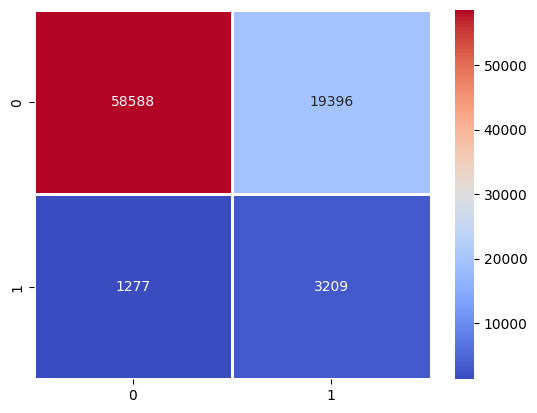

In [ ]:
cm = confusion_matrix(Y_teste_p_maus, class_predicoes)
sns.heatmap(cm, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

In [ ]:
print(accuracy_score(Y_teste_p_maus, class_predicoes))
print(f1_score(Y_teste_p_maus, class_predicoes))
print(precision_score(Y_teste_p_maus, class_predicoes))

0.7493270280101855
0.2369052452844118
0.14195974341959744


In [ ]:
Y_teste = Y_teste.reset_index()
Y_teste.columns = ['Index', 'var_resposta']
Y_teste["score"] = pred_Y*1000

In [ ]:
Y_teste

,Index,var_resposta,score
0,1,0,988.361225
1,4,0,968.053919
2,8,0,787.593963
3,19,0,993.435218
4,28,0,993.737139
...,...,...,...
82465,411437,0,989.616515
82466,411445,0,994.129394
82467,411448,0,992.028619
82468,411454,0,987.942559


In [ ]:
Y_teste['var_resposta'].value_counts()

,count
var_resposta,
0,78076
1,4394


In [ ]:
 from scipy.stats import ks_2samp

 ks_2samp(Y_teste[Y_teste["var_resposta"]== 1 ]['score'],  Y_teste[Y_teste["var_resposta"]== 0 ]['score']) #0.4635352798685593


KstestResult(statistic=0.47154967384346375, pvalue=0.0, statistic_location=945.3717382897511, statistic_sign=1)

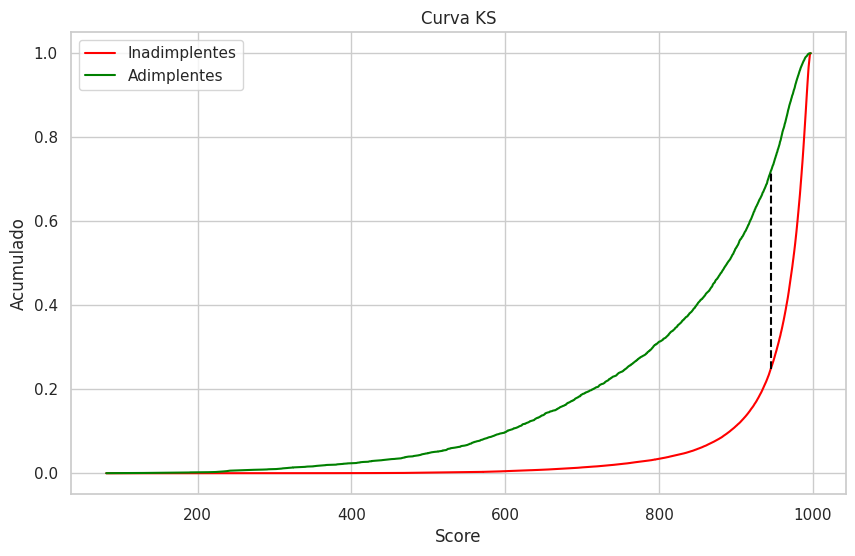

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Exemplo de dados
clientes_maus = Y_teste[Y_teste["var_resposta"] == 0 ]['score']  # Scores para clientes maus
clientes_bons = Y_teste[Y_teste["var_resposta"] == 1 ]['score']  # Scores para clientes bons

# Calcular CDF
x_maus = np.sort(clientes_maus)
y_maus = np.arange(1, len(x_maus) + 1) / len(x_maus)

x_bons = np.sort(clientes_bons)
y_bons = np.arange(1, len(x_bons) + 1) / len(x_bons)

# Calcular a diferença entre as CDFs
x_combined = np.unique(np.concatenate((x_maus, x_bons)))
cdf_maus = np.interp(x_combined, x_maus, y_maus, left=0, right=1)
cdf_bons = np.interp(x_combined, x_bons, y_bons, left=0, right=1)

# Calcular KS
ks_values = np.abs(cdf_maus - cdf_bons)
ks = np.max(ks_values)
ks_index = np.argmax(ks_values)
ks_x = x_combined[ks_index]
ks_y_maus = cdf_maus[ks_index]
ks_y_bons = cdf_bons[ks_index]

# Plotar CDF
plt.figure(figsize=(10, 6))
plt.plot(x_combined, cdf_maus, color='red', label='Inadimplentes')
plt.plot(x_combined, cdf_bons, color='green', label='Adimplentes')

# Linha conectando as CDFs no ponto KS
plt.plot([ks_x, ks_x], [ks_y_maus, ks_y_bons], color='black', linestyle='--')

plt.xlabel('Score')
plt.ylabel('Acumulado')
plt.title('Curva KS')
plt.legend()
#plt.grid()
#plt.text(ks_x, (ks_y_maus + ks_y_bons) / 2, f'KS = {ks:.2f}', fontsize=12, ha='left')

plt.show()

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.9 MB/s eta 0:00:00


In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(class_lgbm)


In [ ]:

shap_values = explainer(X_treino)

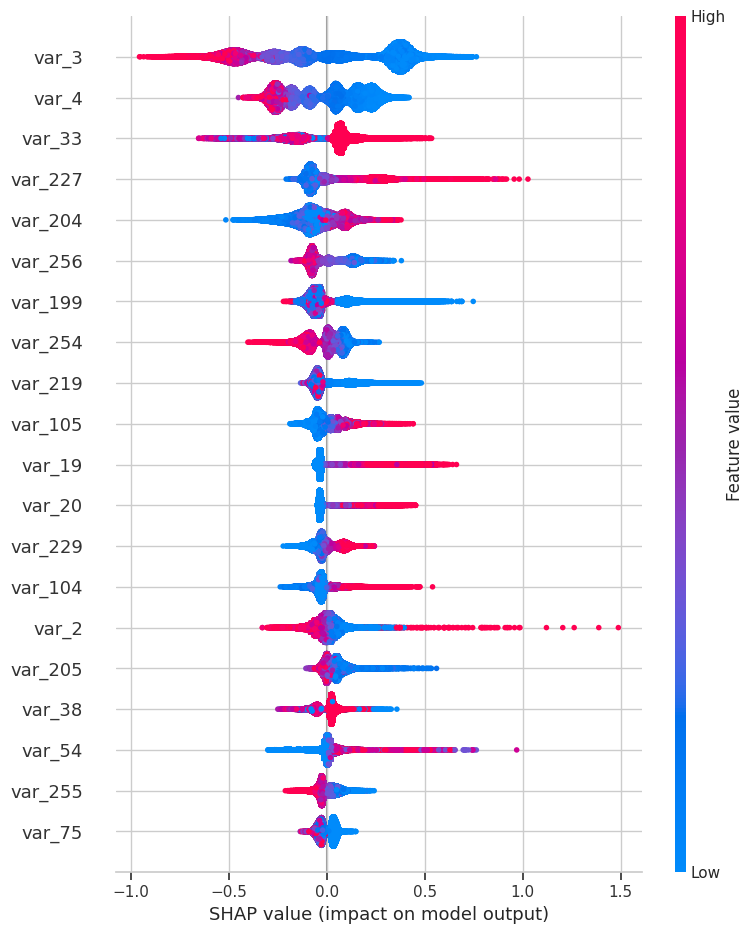

In [ ]:
shap.summary_plot(shap_values, X_treino,plot_type="dot")

In [ ]:
shap.dependence_plot('var_2', shap_values, X_treino)

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

Features more importantes


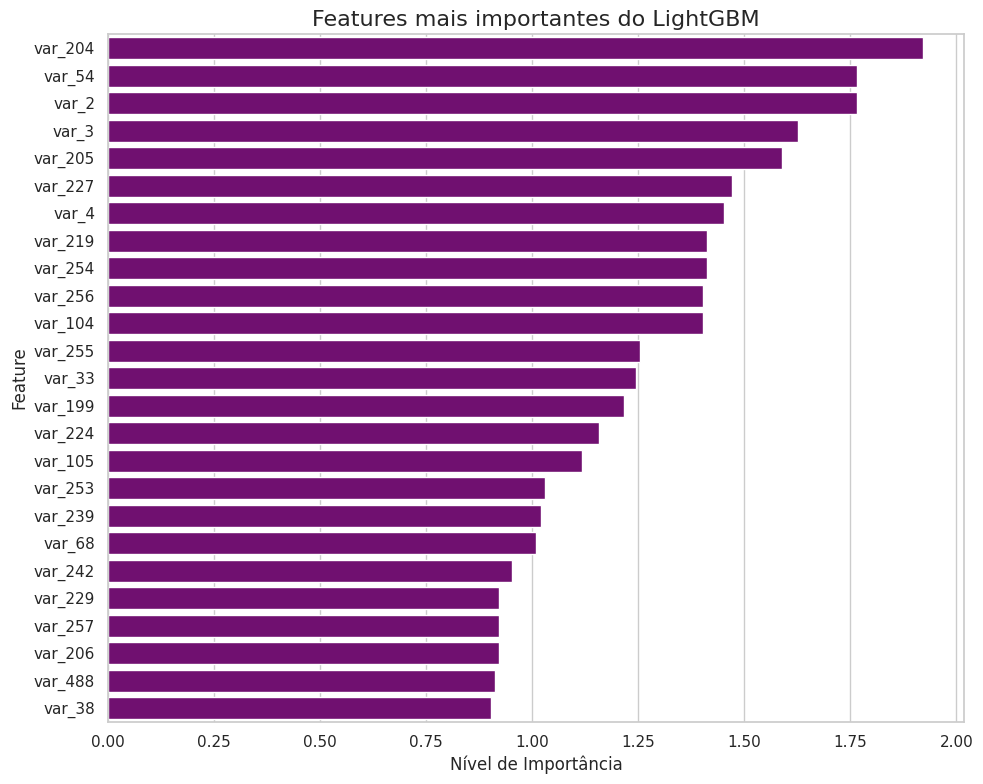

3243
31.794117647058822


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = class_lgbm.feature_importances_
features = class_lgbm.feature_name_

# Criando um DataFrame com as variáveis e suas importâncias
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df['Importancia_Normalizada'] = (importance_df['Importance'])/sum(importance_df['Importance'])*100
# Ordenar pelo nível de importância e pegar as top 25
importance_df = importance_df.sort_values(by='Importancia_Normalizada', ascending=False).head(25)

# Configurar o tamanho e estilo do gráfico
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Criar o gráfico de barras horizontal
sns.barplot(x='Importancia_Normalizada', y='Feature', data=importance_df, color = 'purple')
            #palette='viridis')

# Adicionar título e rótulos
plt.title('Features mais importantes do LightGBM', fontsize=16)
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()
print(sum(importance_df['Importance']))
print(sum(importance_df['Importancia_Normalizada']))

In [ ]:
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html